<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objectif" data-toc-modified-id="Objectif-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Objectif</a></span></li><li><span><a href="#Chargement-des-Packages" data-toc-modified-id="Chargement-des-Packages-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Chargement des Packages</a></span></li><li><span><a href="#Chargement-du-dataset" data-toc-modified-id="Chargement-du-dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Chargement du dataset</a></span></li><li><span><a href="#Analyse-Statistique" data-toc-modified-id="Analyse-Statistique-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Analyse Statistique</a></span><ul class="toc-item"><li><span><a href="#Analyse-Univariée" data-toc-modified-id="Analyse-Univariée-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Analyse Univariée</a></span><ul class="toc-item"><li><span><a href="#Variables-numériques" data-toc-modified-id="Variables-numériques-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Variables numériques</a></span></li><li><span><a href="#Variable-catégorique" data-toc-modified-id="Variable-catégorique-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Variable catégorique</a></span></li></ul></li><li><span><a href="#Analyse-Multivariée" data-toc-modified-id="Analyse-Multivariée-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Analyse Multivariée</a></span><ul class="toc-item"><li><span><a href="#Retour-sur-les-corrélations" data-toc-modified-id="Retour-sur-les-corrélations-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Retour sur les corrélations</a></span></li><li><span><a href="#Relations-entre-les-variables" data-toc-modified-id="Relations-entre-les-variables-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Relations entre les variables</a></span></li></ul></li></ul></li><li><span><a href="#Encodage-de-la-variable-catégorique" data-toc-modified-id="Encodage-de-la-variable-catégorique-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Encodage de la variable catégorique</a></span></li><li><span><a href="#Concaténation-avec-la-dataframe-initiale" data-toc-modified-id="Concaténation-avec-la-dataframe-initiale-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Concaténation avec la dataframe initiale</a></span></li><li><span><a href="#Réduction-dimensionnelle" data-toc-modified-id="Réduction-dimensionnelle-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Réduction dimensionnelle</a></span><ul class="toc-item"><li><span><a href="#Normalisation" data-toc-modified-id="Normalisation-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Normalisation</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>PCA</a></span><ul class="toc-item"><li><span><a href="#Debugging" data-toc-modified-id="Debugging-7.2.1"><span class="toc-item-num">7.2.1&nbsp;&nbsp;</span>Debugging</a></span></li></ul></li></ul></li></ul></div>

# Objectif

L'objectif de notre étude est de créer une application qui, lorsque l'on entre un produit alimentaire d'origine étrangère, nous suggère un produit équivalent d'origine française. 

Ce deuxième notebook utilisera le dataset nettoyé obtenu à l'issue de la première partie du projet, et contiendra les analyses statistiques ainsi que la création du modèle de suggestion de produit.

# Chargement des Packages

In [1]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import seaborn as sns
import requests
import os
import missingno as msno
#import prince
import scipy.spatial as spatial
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pd.options.mode.chained_assignment = None 

# Chargement du dataset

Le premier notebook a créé un dossier data dans lequel on a enregistré un fichier *cleandata.csv*. C'est celui-ci que l'on charge :

In [2]:
cleandata = pd.read_csv("./data/cleandata.csv")

# Analyse Statistique

## Analyse Univariée

### Variables numériques

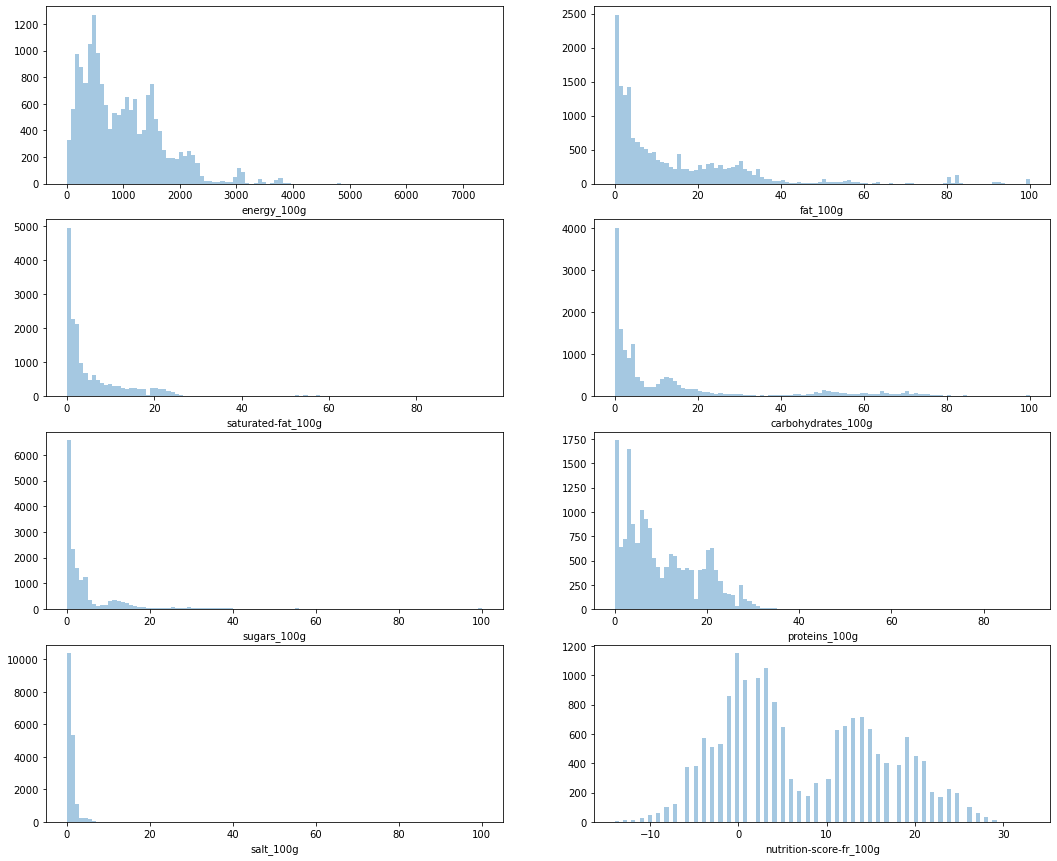

In [3]:
fig, axes = plt.subplots(4, 2, figsize = (18, 15))
axes = axes.ravel()
for idx, col in enumerate(cleandata.loc[:, "energy_100g" :].columns):
    #axes[idx].hist(cleandata.loc[:, col], bins = 100)
    sns.distplot(cleandata.loc[:, col], ax = axes[idx], hist = True, kde = False, bins = 100)

### Variable catégorique

Regardons maintenant la distribution de notre variable catégorique *categories_en* :

Text(0, 0.5, "Fréquence d'apparition")

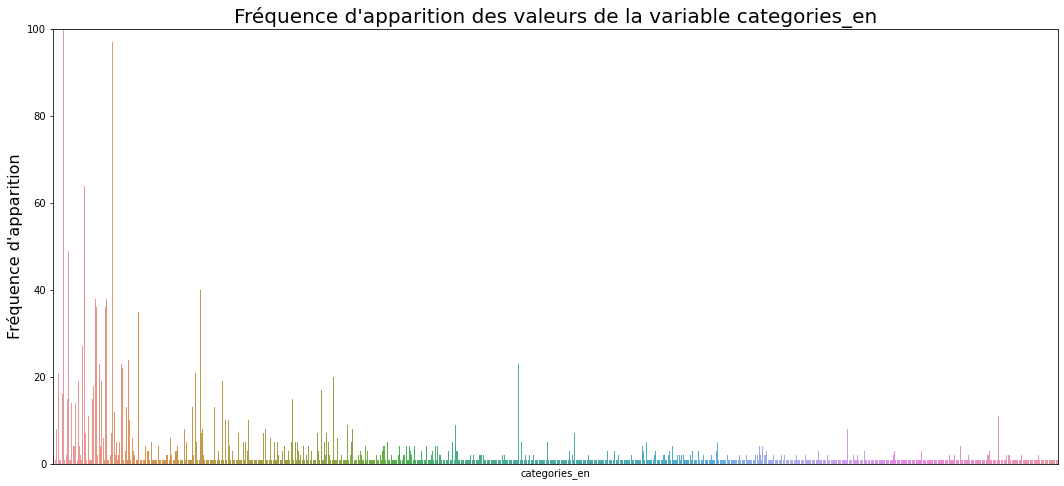

In [4]:
fig, ax = plt.subplots(figsize = (18, 8))
sns.countplot(cleandata.loc[:, "categories_en"], ax = ax)
plt.tick_params(
    axis='x',          # Modification sur l'axe X
    which='both',      # Tous les ticks sont concernés (majeurs et mineurs)
    bottom=False,      # les ticks du bas sont désactivés
    top=False,         # idem haut
    labelbottom=False) # les labels du bas sont désactivés

plt.ylim(0, 100)
plt.title("Fréquence d'apparition des valeurs de la variable categories_en", fontsize = 20)
plt.ylabel("Fréquence d'apparition", fontsize = 16)

Il y a un très grand nombre de catégories différentes :

In [5]:
len(cleandata.loc[:, "categories_en"].unique())

6759

L'histogramme nous donne les informations suivantes :

* La plupart des catégories n'apparaissent qu'une fois
* Un faible nombre de catégories apparaissent plusieurs fois
* Seules un très faible nombre de catégories apparaissent de nombreuses fois

On peut alors s'intéresser à la fréquence des fréquences, et tracer un graphique qui répond à la question "combien a-t-on de catégories qui n'apparaissent qu'une fois ? Combien en a-ton qui apparaissent 30 fois ?" :

(0.0, 150.0)

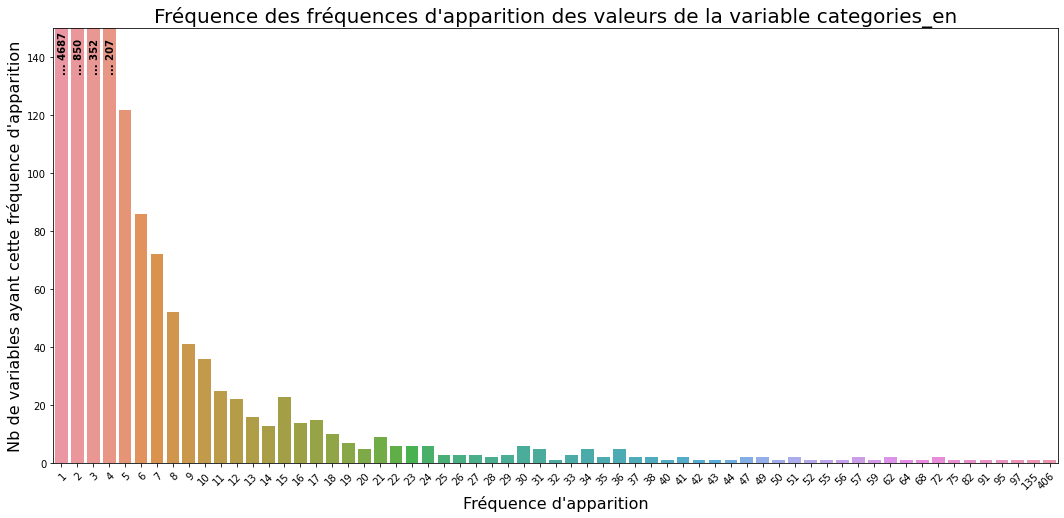

In [75]:
fig, ax = plt.subplots(figsize = (18, 8))
sns.countplot(cleandata.loc[:, "categories_en"].value_counts(), ax = ax)
plt.title("Fréquence des fréquences d'apparition des valeurs de la variable categories_en", fontsize = 20)
plt.ylabel("Nb de variables ayant cette fréquence d'apparition", fontsize = 16)
plt.xlabel("Fréquence d'apparition", fontsize = 16)
plt.xticks(rotation = 45, rotation_mode = "anchor", ha = "right")
for index, value in enumerate(cleandata.loc[:, "categories_en"].value_counts().value_counts().sort_index()):
        if value >= 150:
            plt.text(index - 0.2, 135, "... {}".format(value), color = "black", fontweight = "bold", rotation = 90)
                   
plt.ylim(0, 150)

Plus la fréquence d'apparition est élevée, moins il y a de variable ayant cette fréquence. La répartition en pourcentage est donnée par l'analyse de quantile ci-dessous :

Text(0.5, 0, 'Quantile')

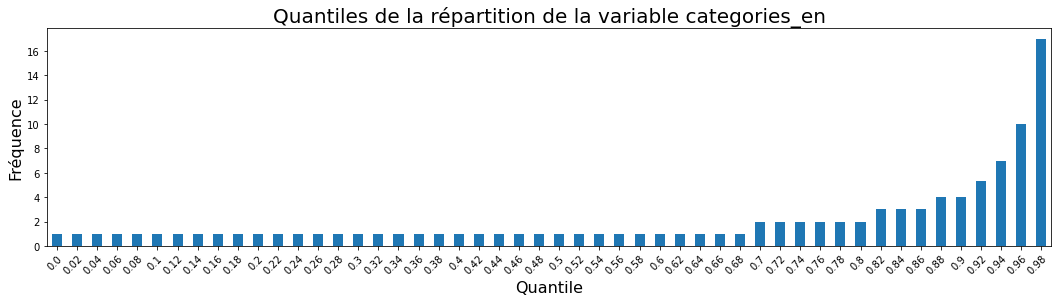

In [7]:
cleandata.loc[:, "categories_en"].value_counts().quantile([round(0.01 * i, 2) for i in range(0, 100, 2)]).plot(figsize = (18,4), 
                                                                                                               kind = "bar")
plt.xticks(rotation = 45, rotation_mode = "anchor", ha = "right")
plt.title("Quantiles de la répartition de la variable categories_en", fontsize = 20)
plt.ylabel("Fréquence", fontsize = 16)
plt.xlabel("Quantile", fontsize = 16)

On voit que 70% des valeurs n'apparaissent qu'une fois, et que 20% des valeurs apparaissent de 2 à 4 fois.

Ensuite, la fréquence d'apparition augmente de façon exponentielle pour chaque pas de quantile sur les 10 derniers pourcents des valeurs.

98% des valeurs apparaissent 16 fois ou moins. Pourtant, on a vu qu'il y avait des valeurs apparaîssant 30, 100 voire 406 fois. Pour les observer, il vaut élargir l'éventail de l'étude de quantiles, entre 0.98 et 1, par petits pas de 0.0005 :

Text(0.5, 0, 'Quantile')

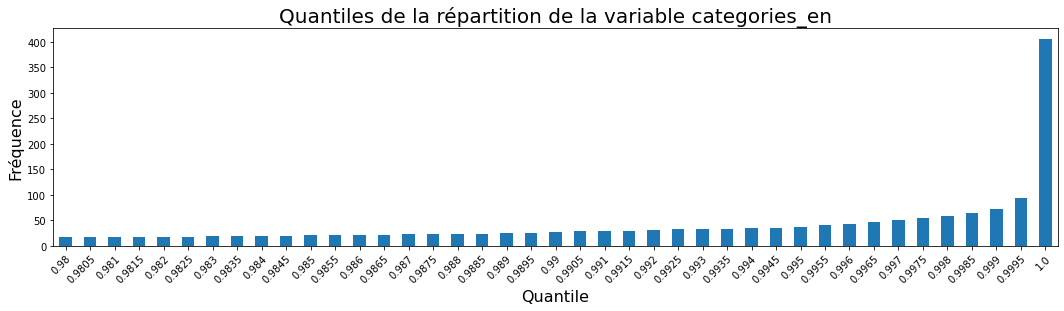

In [8]:
cleandata.loc[:, "categories_en"].value_counts().quantile([round(0.0001 * i, 4) for i in range(9800, 10001, 5)]).plot(figsize = (18,4), 
                                                                                                               kind = "bar")
plt.xticks(rotation = 45, rotation_mode = "anchor", ha = "right")
plt.title("Quantiles de la répartition de la variable categories_en", fontsize = 20)
plt.ylabel("Fréquence", fontsize = 16)
plt.xlabel("Quantile", fontsize = 16)

Les valeurs relativement fréquentes de la variable categories_en représentent une très faible minorité du dataset. Elles sont les suivantes :

Text(0.5, 0, 'Fréquence')

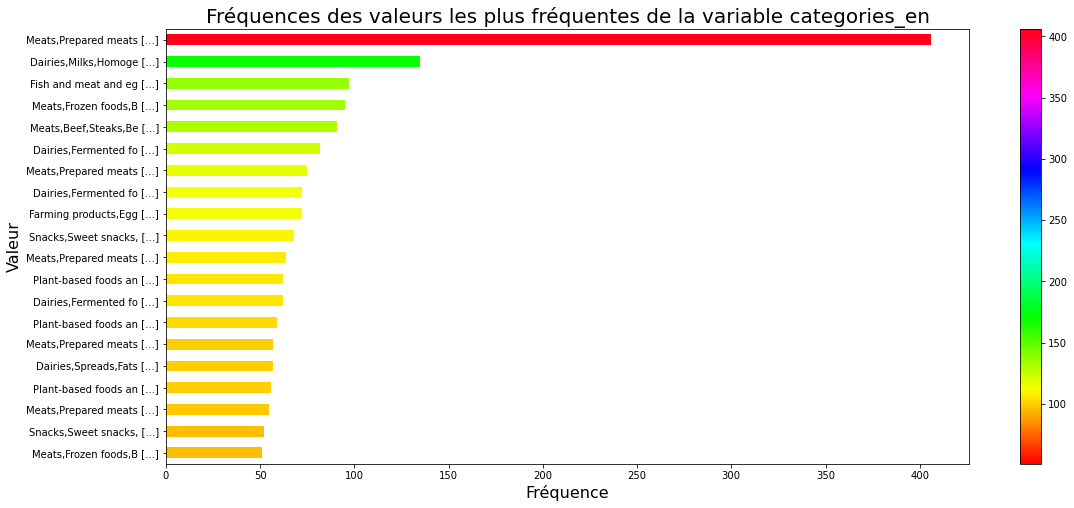

In [4]:
y = cleandata.loc[:, "categories_en"].value_counts().sort_values(ascending = True).tail(20)
colors = cm.hsv(y / float(max(y)))
y.plot(figsize = (18, 8), kind = "barh", color = colors)
plt.yticks(ticks = [i for i in range(20)], labels = ["{} [...]".format(mot[0:20]) for mot in y.index])
plot = plt.scatter(y, y, c = y, cmap = 'hsv')
plt.colorbar(plot)
plt.title("Fréquences des valeurs les plus fréquentes de la variable categories_en", fontsize = 20)
plt.ylabel("Valeur", fontsize = 16)
plt.xlabel("Fréquence", fontsize = 16)

## Analyse Multivariée

### Retour sur les corrélations

Nous avions dans le premier notebook que les variables ont une certaine corrélation entre elles. Pour rappel, voici la heatmap de corrélation :

Text(0.5, 1.0, 'Heatmap de Corrélation')

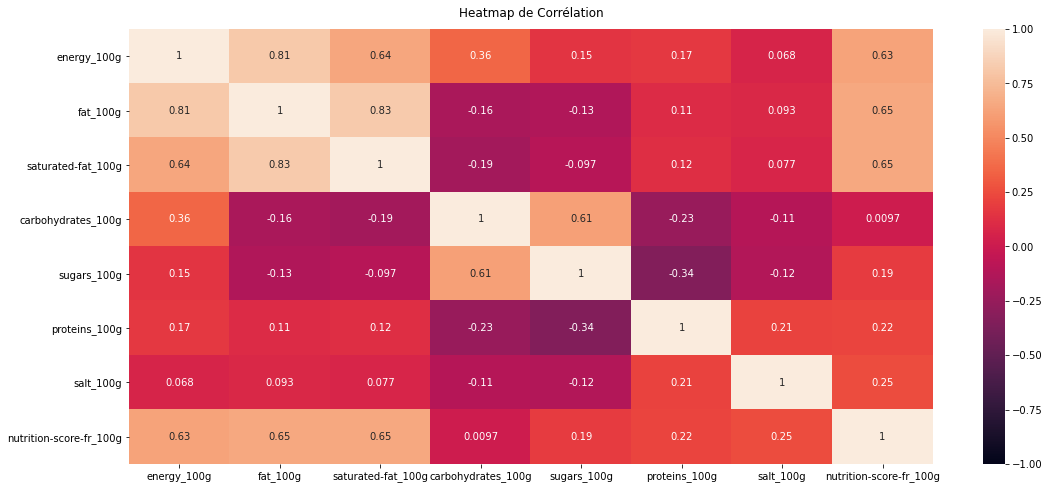

In [10]:
plt.figure(figsize = (18, 8))
corrheatmap = sns.heatmap(cleandata.loc[:, "energy_100g":].corr(),
                          vmin = -1, vmax = 1, annot = True)
corrheatmap.set_title("Heatmap de Corrélation", fontdict = {"fontsize" : 12}, pad = 12)

### Relations entre les variables

Voyons maintenant comment ce traduisent ces corrélations lorsque l'on trace les relations des variables entre elles sur un pairplot :

Text(0.5, 1.08, 'Pairplot des variables numériques du dataset')

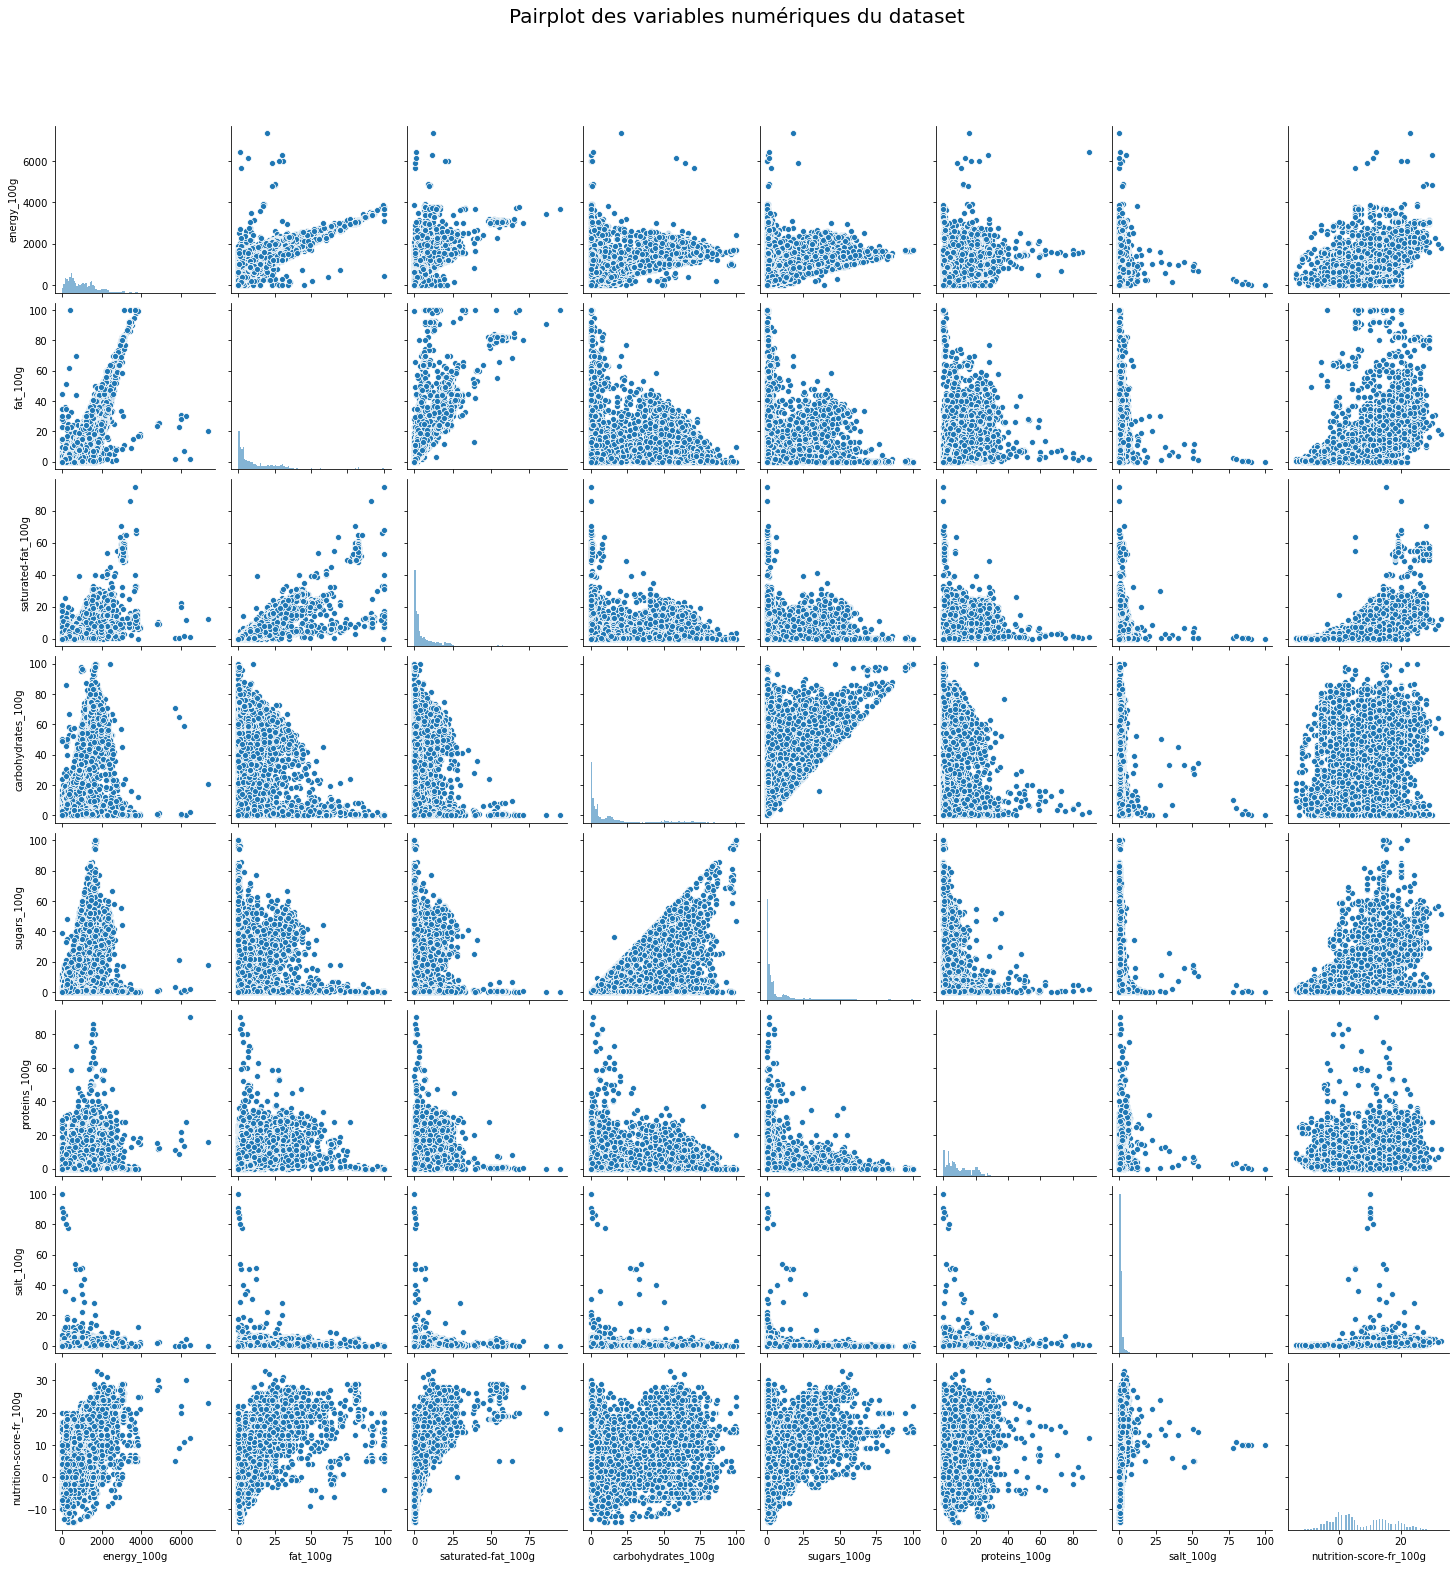

In [11]:
g = sns.pairplot(cleandata.loc[:, "energy_100g":], height = 2.5, diag_kind = "hist", diag_kws = {"alpha" : 0.55, "bins" : 100})
g.fig.suptitle("Pairplot des variables numériques du dataset", y = 1.08, fontsize = 20)
    

Certaines corrélations élevées sont alors expliquées dans cette analyse multivariée. En effet, on voit alors que, naturellement, la teneur en graisse est forcément supérieure à la teneur en graisses saturées qui en est un sous-ensemble, et de même avec les carbohydrates (glucides) et le sucre.

Du côté des autres corrélations élevées d'environ 0.7, on voit effectivement que l'énergie a une relation linéaire avec la teneur en lipides, mais les corrélations entre le nutriscore avec l'énergie, les lipides et les graisses saturées est bien moins visible :

Text(0.5, 0.98, 'Relation entre le nutriscore et ses variables à corrélation élevée')

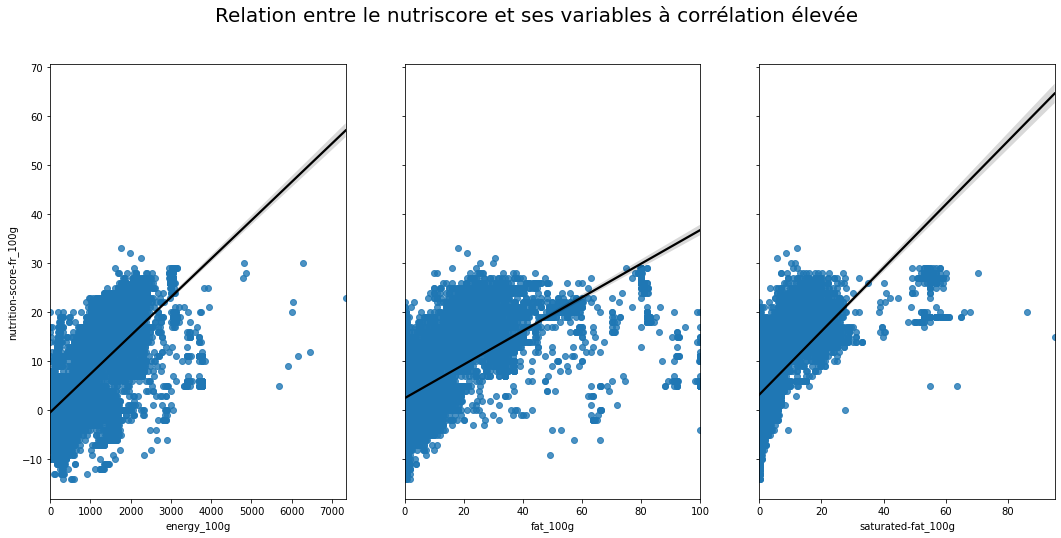

In [12]:
fig, axes = plt.subplots(1, 3, figsize = (18, 8), sharey = "all")
axes = axes.ravel()
for idx, col in enumerate(cleandata.loc[:, "energy_100g" : "saturated-fat_100g"].columns):
    
    sns.regplot(cleandata.loc[:, col], cleandata.loc[:, "nutrition-score-fr_100g"], ax = axes[idx], line_kws = {"color" : "black"})
    if idx > 0:
        axes[idx].set_ylabel("")
    
plt.suptitle("Relation entre le nutriscore et ses variables à corrélation élevée", fontsize = 20)

Il y a une tendance à la hausse en fonction des teneurs en énergie ou graisses, mais cette relation linéaire n'explique que très peu la loi sous-jacente. 

Globalement, les variables ont toutes une corrélation plus ou moins forte entre elles ; ces relations ont des chances de se traduire par une proximité entre certains groupes de points dans le nuage global. Il est donc probable qu'un regroupement par clustering soit efficace.

# Encodage de la variable catégorique

Comme nous l'avons vu lors de l'analyse univariée, la variable *categories_en* a de nombreuses valeurs uniques que nous encodons da la façon suivante :

In [13]:
cat_df = pd.get_dummies(cleandata["categories_en"])

Nous obtenons la dataframe suivante :

In [14]:
cat_df.head().iloc[:, 0:6]

,4,"Aliments-et-boissons-a-base-de-vegetaux,Boissons,Boissons-aux-fruits,Boissons-a-base-de-vegetaux","Artisan products,Crêpes and galettes,Crêpes,fr:Crêpes de froment","Bee products,Pollens","Beurres,Beurres-de-creme-douce,Matiere-grasse-laitiere,Matieres-grasses,Matieres-grasses-animales,Matieres-grasses-a-tartiner,Produits-laitiers,Produits-laitiers-a-tartiner,Produits-a-tartiner",Beverages
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [15]:
print("La dataframe cat_df contient {} observations et {} variables".format(cat_df.shape[0], cat_df.shape[1]))

La dataframe cat_df contient 17540 observations et 6759 variables


Lors de l'analysse univariée, nous avons vu que la plupart des valeurs de *categories_en* n'apparaissent qu'une fois, si bien que notre dataframe encodée *cat_df* sera creuse, c'est-à-dire qu'elle contiendra une large majorité de 0, comme le montre la heatmap ci-dessous :

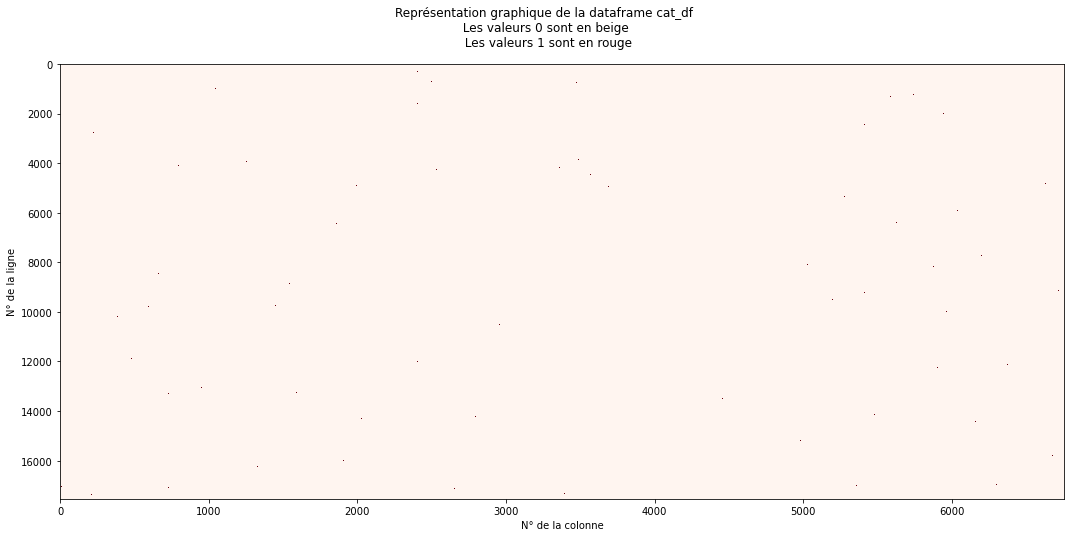

In [16]:
fig, ax = plt.subplots(figsize = (18, 8))
ax.imshow(cat_df, cmap = plt.cm.Reds, interpolation = "nearest", aspect = "auto")
plt.suptitle("Représentation graphique de la dataframe cat_df \n Les valeurs 0 sont en beige \n Les valeurs 1 sont en rouge")
plt.xlabel("N° de la colonne")
plt.ylabel("N° de la ligne");

# Concaténation avec la dataframe initiale

Maintenant que nous avons encodé notre variable catégorique, on remplace dans *cleandata* la colonne *categories_en* par *cat_df* :

In [17]:
foodinfo = pd.concat([cleandata.drop(columns = "categories_en"), cat_df], axis = 1)

Notre dataset a les caractéristiques suivantes :

In [18]:
print("La dataframe cat_df contient {} observations et {} variables".format(foodinfo.shape[0], foodinfo.shape[1]))

La dataframe cat_df contient 17540 observations et 6770 variables


Pour la suite de l'étude, nous séparons *foodinfo* entre les variables d'identification (**id**) et celles de mesure (**ms**) :

In [19]:
foodinfo_id = foodinfo.loc[:, "product_name" : "origins_en"]

In [20]:
foodinfo_ms = foodinfo.loc[:, "energy_100g":]

# Réduction dimensionnelle

Puisqu'elle est obtenue à partir de *cat_df*, notre dataframe *foodinfo* sera naturellement elle aussi creuse. La majorité de ses cellules sont donc pauvres en information, et son ration lignes/colonnes est de 2.6 : 1, ce qui fragilisera fortement notre clustering.

Pour palier à ce problème, nous procédons à une réduction de dimension au travers d'un PCA, qui nous permettra de conserver un maximum d'information en éliminant une grande quantité de colonnes ; cependant, le dataset que l'on obtiendra ainsi ne sera plus interprétable.

## Normalisation

La première étape consiste à normaliser les données :

In [21]:
foodinfo_ms_norm = StandardScaler().fit_transform(foodinfo_ms)

## PCA

On applique désormais la réduction dimensionnelle sur les données normalisées :

In [71]:
pca = PCA(n_components = 1000)

In [72]:
pca.fit(foodinfo_ms_norm)

PCA(n_components=1000)

In [73]:
pca.explained_variance_ratio_.sum()

0.14889741191511263

## MCA

In [25]:
foodinfo_ms2 = foodinfo.iloc[:, 3:11]


In [36]:
from sklearn.preprocessing import MinMaxScaler

In [39]:
info = MinMaxScaler(feature_range = (0, 100)).fit_transform(foodinfo_ms2)
info = pd.concat([pd.DataFrame(info), pd.get_dummies(cleandata["categories_en"])], axis = 1)


In [40]:
import mca
mca_ben = mca.MCA(info)

In [41]:
mca_ind = mca.MCA(info, benzecri = False)

In [43]:
data = {'Iλ': pd.Series(mca_ind.L),
        'τI': mca_ind.expl_var(greenacre=False, N=6765),
        'Zλ': pd.Series(mca_ben.L),
        'τZ': mca_ben.expl_var(greenacre=False, N=6765),
        'cλ': pd.Series(mca_ben.L),
        'τc': mca_ind.expl_var(greenacre=True, N=6765)}

# 'Indicator Matrix', 'Benzecri Correction', 'Greenacre Correction'
columns = ['Iλ', 'τI', 'Zλ', 'τZ', 'cλ', 'τc']
table2 = pd.DataFrame(data=data, columns=columns).fillna(0)
table2.index += 1
table2.loc['Σ'] = table2.sum()
table2.index.name = 'Factor'

table2

,Iλ,τI,Zλ,τZ,cλ,τc
Factor,,,,,,
1,0.289831,0.003631,0.083941,6.149552e-02,0.083941,6.046588e-02
2,0.111072,0.001392,0.012308,9.016768e-03,0.012308,8.865797e-03
3,0.091947,0.001152,0.008430,6.175474e-03,0.008430,6.072076e-03
4,0.086795,0.001087,0.007510,5.501806e-03,0.007510,5.409688e-03
5,0.056072,0.000703,0.003128,2.291879e-03,0.003128,2.253506e-03
...,...,...,...,...,...,...
6762,0.000494,0.000006,0.000000,8.794397e-08,0.000000,8.647149e-08
6763,0.000380,0.000005,0.000000,3.962799e-08,0.000000,3.896448e-08
6764,0.000311,0.000004,0.000000,1.949474e-08,0.000000,1.916833e-08


Le MCA le plus efficace est celui avec correction de Benzécri et sans correction de Greenacre. 

Néanmois, la variance expliquée par les premieres valeurs singulières sont faibles (6% pour le premier) ; voyons ce qu'on obtient avec les 1000 premières valeurs :

In [78]:
mca_ben.expl_var(greenacre=False, N=6765)[0:1000].sum()

0.5772552786576483

Seulement 57% de la variance est expliquée avec 1000 composants principaux. 

Le tableau suivant montre la variance expliquée en fonction du nombre de composants retenus :

Text(0.5, 0, 'Nombre de composants')

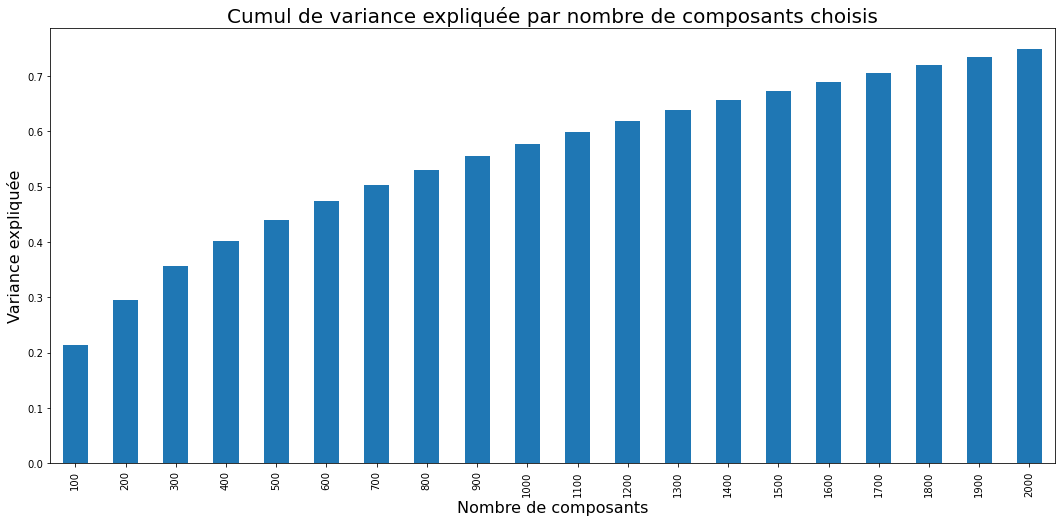

In [69]:
pd.DataFrame({"var_exp" : [mca_ben.expl_var(greenacre=False, N=6765)[0:i].sum() for i in range(100, 2100, 100)]},
            index = [i for i in range(100, 2100, 100)]).plot(kind = "bar", figsize = (18,8), legend = None)
plt.title("Cumul de variance expliquée par nombre de composants choisis", fontsize = 20)
plt.ylabel("Variance expliquée", fontsize = 16)
plt.xlabel("Nombre de composants", fontsize = 16)

Notre réduction dimensionnelle perd trop d'information et est donc inexploitable. Nous choisirons donc de modifier la variable *categories_en* en gardant les 20 valeurs apparaîssant plus de 50 fois, et en convertissant toutes les autres en "others".

# Feature Engineering : modification de la variable catégorique

Dans l'analyse univariée de la variable catégorique, nous avions déjà enregistré les noms des 20 valeurs de *categories_en* apparaîssant plus de 50 fois dans la varyable **y***. C'est celle-ci que l'on utilise pour renommer toutes les autres valeurs :

In [5]:
cleandata.loc[~cleandata["categories_en"].isin(y.index.tolist()), "categories_en"] = "Others"

On obtient alors la dataframe suivante :

In [6]:
cleandata.head()

,product_name,brands,categories_en,origins_en,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
0,Blanquette de Volaille et son Riz,Comme J’aime,Others,France,450.0,2.2,0.9,15.3,0.5,6.8,0.70,0.0
1,Financiers aux Amandes,Bijou,Others,France,1866.0,23.0,10.0,51.0,39.0,8.0,0.55,23.0
2,Foie gras de canard du Périgord,Le Moulin de Moreau,Others,France,2276.0,56.0,23.0,23.0,0.6,7.1,1.90,24.0
3,Salade végétarienne,Crous Languedoc Roussillon,Others,France,252.0,1.9,0.3,7.4,2.2,2.0,0.30,-1.0
4,Salade fermière,Crous Languedoc Roussillon,Others,France,582.0,6.8,3.8,7.6,1.4,10.8,0.80,1.0


# Preuve de concept (POC) : faisabilité et test de l'application

Suite à toutes ces étapes de nettoyage, d'analyse exploratoire et d'analyse statistique, nous allons désormais étudier la faisabilité de notre idée d'application. 

Pour rappel, nous souhaitons, à partir d'un nom de produit, suggérer un produit équivalent français.

## Encodage de la variable catégorique

Maintenant que notre variable *categories_en* n'admet plus que 21 valeurs, on l'encode à nouveau :

In [25]:
cat_data = pd.get_dummies(cleandata.loc[:, "categories_en"])
cleandata2 = pd.concat([cleandata.drop(columns = "categories_en"), cat_data], axis = 1)

## Séparation entre variables d'identification et variables de mesures

Nous séparons à présent les variables d'identification, qui nous permettent de nommer un produit, des variables de mesure, qui nous permettent de faire notre recherche de similarité :

In [8]:
idvars = cleandata2.loc[:, :"origins_en"]
measvars = cleandata2.loc[:, "energy_100g":]

Nos dataframes *idvars* et *measvars* prennent la forme suivante :

In [26]:
idvars.head() 
measvars.head()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,nutrition-score-fr_100g,"Dairies,Fermented foods,Fermented milk products,Cheeses","Dairies,Fermented foods,Fermented milk products,Yogurts","Dairies,Fermented foods,Fermented milk products,Yogurts,Plain yogurts","Dairies,Milks,Homogenized milks,Semi-skimmed milks,UHT Milks","Dairies,Spreads,Fats,Spreadable fats,Animal fats,Milkfat,Dairy spread,Butters,Half-salted butter","Farming products,Eggs,Chicken eggs,Free-range chicken eggs","Fish and meat and eggs,Foies gras,Foies gras from ducks,Whole foies gras","Meats,Beef,Steaks,Beef steaks,Fresh meats,Ground steaks,Ground beef steaks,Fresh ground steaks,Fresh ground beef steaks","Meats,Frozen foods,Beef,Frozen meats,Meat preparations,Beef preparations,Frozen meat preparations,Ground meat preparations,Frozen ground meat preparations,Ground beef preparations,Frozen ground beef preparations","Meats,Frozen foods,Beef,Steaks,Beef steaks,Frozen meats,Ground steaks,Frozen steaks,Ground beef steaks,Frozen ground steaks,Frozen ground beef steaks","Meats,Prepared meats","Meats,Prepared meats,Hams,Cured ham,Dried hams,Raw-cured-ham","Meats,Prepared meats,Hams,White hams","Meats,Prepared meats,Hams,White hams,Products with reduced salt,Prepared meats with less salt,White hams with less salt","Meats,Prepared meats,fr:Charcuteries diverses,Pâté,Pork Pâtés,Country-style Pâtés",Others,"Plant-based foods and beverages,Beverages,Plant-based beverages,Fruit-based beverages,Juices and nectars,Fruit juices,Squeezed juices,Apple juices,Squeezed apple juices","Plant-based foods and beverages,Plant-based foods,Legumes and their products,Canned foods,Fruits and vegetables based foods,Legumes,Canned plant-based foods,Vegetables based foods,Canned vegetables,Green beans,Canned legumes,Canned green beans","Plant-based foods and beverages,Plant-based foods,Snacks,Cereals and potatoes,Salty snacks,Appetizers,Chips and fries,Crisps,Potato crisps,Potato crisps in sunflower oil","Snacks,Sweet snacks,Biscuits and cakes,Biscuits","Snacks,Sweet snacks,Biscuits and cakes,Biscuits,Shortbread cookies"
0,450.0,2.2,0.9,15.3,0.5,6.8,0.70,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1866.0,23.0,10.0,51.0,39.0,8.0,0.55,23.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2276.0,56.0,23.0,23.0,0.6,7.1,1.90,24.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,252.0,1.9,0.3,7.4,2.2,2.0,0.30,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,582.0,6.8,3.8,7.6,1.4,10.8,0.80,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


## Test étape par étape du concept

Regardons, parmis toutes nos observations, celles qui sont d'origine étrangère :

In [27]:
idvars.loc[idvars["origins_en"] == "Foreign", :]

,product_name,brands,origins_en
11,10 wafer thin brunswick ham slices,By Sainsbury's,Foreign
16,Prosciutto Cappelletti,"Saintsbury's, Sainsbury, By sainsbury's",Foreign
17,Lindt Gold Easter Bunny Milk Chocolate,Lindt,Foreign
23,Simply gourmet soft-ripened cheese with a red ...,"Simply,Rougette",Foreign
24,Cocoa creme soft caramels,Werthers Original,Foreign
...,...,...,...
17520,Biscuits d'avoine Biowise,Biowise,Foreign
17528,"Bio Cornflakes, Ungesüßt",Verival,Foreign
17529,Orangenwasser,Vöslauer,Foreign
17531,Bio-Gemüsesuppe Mediteran,Spar Natur Pur,Foreign


Nous allons faire ce test sur le premier résultat, le produit "10 wafer thin brunswick ham slices" de Sainsbury's. Il porte l'index n°11 de notre dataset *idvars* ; ses caractéristiques sont donc elles aussi dans la onzième observation de *measvars* :

In [28]:
testinput = measvars.iloc[11, :]

In [29]:
testinput

energy_100g                                                                                                                                                                                                                                            661.0
fat_100g                                                                                                                                                                                                                                                 7.8
saturated-fat_100g                                                                                                                                                                                                                                       3.2
carbohydrates_100g                                                                                                                                                                                                                               

Nous allons désormais chercher le voisin le plus proche de ce vecteur. Pour cela, nous allon créer un arbre de proximité cKDTree à partir de tous les points de *measvars*. 

In [71]:
point_tree = spatial.cKDTree(measvars)

Nous demandons à l'arbre de nous donner l'indice des points les plus proches de notre vecteur input :

In [72]:
nearest = point_tree.query_ball_point(testinput, 2)

Nous prenons le premier élément du résultat, qui est le point le plus proche :

In [49]:
nearest[0]

15229

Regardons à quel produit cet indice correspond :

In [50]:
idvars.iloc[nearest[0], :]

product_name    Rôti de porc cuit fumé
brands            Haute Loue Salaisons
origins_en                      France
Name: 15229, dtype: object

Bonne nouvelle, nous obtenons du porc, comme notre produit étranger. Voyons quelles sont ses caractéristiques, et comparons les au vecteur input :

In [70]:
cleandata.loc[cleandata["product_name"].isin([idvars.iloc[nearest[0], 0] , idvars.iloc[11, 0]]), :]

,product_name,brands,categories_en,origins_en,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
11,10 wafer thin brunswick ham slices,By Sainsbury's,Others,Foreign,661.0,7.8,3.2,0.6,0.6,21.2,2.0,12.0
15229,Rôti de porc cuit fumé,Haute Loue Salaisons,Others,France,661.0,7.4,3.4,0.5,0.5,22.0,1.7,11.0


On voit donc que les produits sont très similaires. Pour ce test, la suggestion fonctionne.

**On en déduit donc que les données que l'on a à disposition nous permettent de suggérer un produit français équivalent à un produit étranger. Notre application est faisable**.

## Automatisation

Le but est désormais d'automatiser le processus que nous venons de suivre en une fonction :

In [73]:
def get_similar(product):
    n = 1
    id_index = idvars.index[idvars["product_name"] == product].tolist()[0]
    init_input = measvars.iloc[id_index, :].tolist()
    nearest_points = point_tree.query_ball_point(init_input, n)
    output_frame = idvars.iloc[nearest_points, :]
    output_frame = output_frame.loc[output_frame["origins_en"] == "France", :]
    
    # Si nous ne trouvons pas de voisin dans notre champ de recherche, on l'élargit
    # par incréments de 1
    while output_frame.shape[0] == 0:
        n += 1
        id_index = idvars.index[idvars["product_name"] == product].tolist()[0]
        init_input = measvars.iloc[id_index, :].tolist()
        nearest_points = point_tree.query_ball_point(init_input, n)
        output_frame = idvars.iloc[nearest_points, :]
        output_frame = output_frame.loc[output_frame["origins_en"] == "France", :]
        
    
    return output_frame.iloc[0, :]

Choisissons à nouveau un produit de test :

In [21]:
idvars.loc[idvars["origins_en"] == "Foreign", :]

,product_name,brands,origins_en
11,10 wafer thin brunswick ham slices,By Sainsbury's,Foreign
16,Prosciutto Cappelletti,"Saintsbury's, Sainsbury, By sainsbury's",Foreign
17,Lindt Gold Easter Bunny Milk Chocolate,Lindt,Foreign
23,Simply gourmet soft-ripened cheese with a red ...,"Simply,Rougette",Foreign
24,Cocoa creme soft caramels,Werthers Original,Foreign
...,...,...,...
17520,Biscuits d'avoine Biowise,Biowise,Foreign
17528,"Bio Cornflakes, Ungesüßt",Verival,Foreign
17529,Orangenwasser,Vöslauer,Foreign
17531,Bio-Gemüsesuppe Mediteran,Spar Natur Pur,Foreign


Nous choisissons cette fois le deuxième élément, le Prosciutto Cappelletti :

In [74]:
get_similar("Prosciutto Cappelletti")

product_name    Ma salade bio blé & lentilles
brands                        Instants Nature
origins_en                             France
Name: 15774, dtype: object

In [76]:
get_similar("Prosciutto Cappelletti")[0]

'Ma salade bio blé & lentilles'

In [78]:
cleandata.loc[cleandata["product_name"].isin([get_similar("Prosciutto Cappelletti")[0],"Prosciutto Cappelletti"]), :]

,product_name,brands,categories_en,origins_en,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
16,Prosciutto Cappelletti,"Saintsbury's, Sainsbury, By sainsbury's",Others,Foreign,761.0,4.7,2.0,23.9,0.5,9.6,0.74,-1.0
15774,Ma salade bio blé & lentilles,Instants Nature,Others,France,757.0,5.7,0.5,24.0,2.0,6.9,1.00,0.0


Nous tombons là aussi sur un produit très similaire du point de vue des valeurs nutritionnelle, mais qui est complètement différent : on obtient des lentilles au lieu d'une viande. Il y a donc des axes d'amélioration à explorer.

## Axes d'amélioration